In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re,json,nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
path ='/content/drive/MyDrive/Colab Notebooks/NLP_YOUTUBE_Data/Dataset and Notebook/' 
stopwords_list = path+'book_stopwords.txt'

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

#Dataset Preparation

In [3]:
# Read the data and take only 1000 Reviews
data = pd.read_excel(path+'BookReviews.xlsx')
data.Sentiment = data.Sentiment.replace({1:'Positive',0:'Negative'})
print("Total Reviews:",len(data),
      "\nTotal Positive Reviews:",len(data[data.Sentiment =='Positive']),
      "\nTotal Negative Reviews:",len(data[data.Sentiment=='Negative']))

Total Reviews: 1444 
Total Positive Reviews: 972 
Total Negative Reviews: 472


In [4]:
# print some unprocessed reviews
sample_data = [10,100,150,200,250,300,350,400,450,500,600,650,700,750,800]
for i in sample_data:
      print(data.Review[i],'\n','Sentiment:-- ',data.Sentiment[i],'\n')  

দয়া করে কোনো বাঙালি বইটি কিনবেন না। দেশকে ভালবাসলে ভাষাকে ভালবাসলে বইটিকে বর্জন করুন। 
 Sentiment:--  Negative 

অনুবাদ এর মান আরো ভালো করা উচিত ছিল।😔 
 Sentiment:--  Negative 

ফালতু লুতুপুতু প্রেমকাহিনী 
 Sentiment:--  Negative 

পড়তেই কষ্ট হয় 
 Sentiment:--  Negative 

শংকরের বিখ্যাত এই বইটা অবশেষে শেষ করলাম । বেশ দীর্ঘ সময় নিয়ে পড়ে শেষ করতে হয়েছে এটা । আমার কাছে মনে হয়েছে উপন্যাসের শুরুতে লেখক যেরকম আগ্রহ ধরে রাখতে পেরেছেন পরবর্তীতে আর তেমনটা পারেন নি। পুরো বই জুড়ে লেখক সেই একই শাহজাহান হোটেলের বর্ননা দিয়ে যাচ্ছেন তো যাচ্ছেন ই । মাঝে মাঝে মনে হয়েছে বইটা একটা আবাসিক শান শওকত ওয়ালা হোটেলে কর্মরত কোন এক কর্মচারীর ডায়রী। পুরো বইতে লেখক শাহজাহান হোটেলের নাম নিয়েই গেছেন অথচ এই "শাহজাহান" বানানটাই ইচ্ছে করে বার বার শাজাহান লেখেছেন, যেটা কলকাতা কেন্দ্রীক বুদ্ধিজীবী দের স্বভাব বলুন আর নষ্টামি ই বলুন, এছাড়া আর কিছু নয় ।  
 Sentiment:--  Negative 

এটা কোনো সাইন্স ফিকশন না, পুরাই হতাশ। 
 Sentiment:--  Negative 

সত্য মিথ্যার বেড়াজালে এক চমৎকার কাজ। অনেকাংশেই তথ্য বিকৃতিতে ভরপুর, উপন্যাসের শেষ

In [5]:
stp = open(stopwords_list,'r',encoding='utf-8').read().split()
print(stp)

['এই', 'করে', 'জন্য', 'একটি', 'আমার', 'একটা', 'এর', 'যে', 'তার', 'এবং', 'থেকে', 'ও', 'এ', 'কি', 'কোন', 'আমি', 'আর']


#Data Cleaning

In [6]:
def cleaned_reviews(review):
    """
    This function will remove the unncessary 
    symbols from a review such as punctuation mark, numbers ,emoji. 
    
    Args:
        review: str
        
    Returns:
        cleaned review: str
    """
    review = review.replace('\n', '') #removing new line 
    review = re.sub('[^\u0980-\u09FF]',' ',str(review)) #removing unnecessary punctuation
    return review
                                                 #=========================== 
                                                 ####### Function 2 #########
                                                 #===========================  
def stopwords_info(filename):
    """
    This function will create a stopwords list from the (.txt) file. 
    
    Args:
        filename: str
        
    Returns:
        stp: list of stopwords
        num_of_words: int
    """
    stp = open(filename,'r',encoding='utf-8').read().split()
    num_of_stopwords = len(stp)
    return stp,num_of_stopwords

                                                 #=========================== 
                                                 ####### Function 3 #########
                                                 #===========================  
def stopword_removal(review,stopwords):
    """
    This function will remove the stopwords from a review. 
    
    Args:
        review: str
        stopwords: str
        
    Returns:
        review without stopwords: str
    """
    stp,num_of_stopwords =stopwords_info(stopwords)
    result = review.split()
    reviews = [word.strip() for word in result if word not in stp ]
    reviews =" ".join(reviews)
    return reviews
                                                 #=========================== 
                                                 ####### Function 4 #########
                                                 #===========================               
def process_reviews(review,stopwords,removing_stopwords):
    """
    This function will process all the reviews which includes
    cleaning text and stopword removal.
    
    Args:
        review: str
        stopwords: filename
        removing_stopwords: boolean(True or False) 
        
    Returns:
        cleaned reviews: str
    """
    if removing_stopwords ==False:
        reviews = cleaned_reviews(review)
        
    else:
        reviews = cleaned_reviews(review)
        reviews = stopword_removal(reviews,stopwords)
        
    return reviews    


In [7]:
# Apply the function into the dataframe
data['cleaned'] = data['Review'].apply(process_reviews,stopwords = stopwords_list,removing_stopwords = True)  
# print some cleaned reviews from the dataset
sample_data = [10,100,150,200,250,300,350,400,450,500,600,650,700,750,800]
for i in sample_data:
      print('Original:\n',data.Review[i],'\nCleaned:\n',data.cleaned[i],'\n','Sentiment:-- ',data.Sentiment[i],'\n')  

Original:
 দয়া করে কোনো বাঙালি বইটি কিনবেন না। দেশকে ভালবাসলে ভাষাকে ভালবাসলে বইটিকে বর্জন করুন। 
Cleaned:
 দয়া কোনো বাঙালি বইটি কিনবেন না দেশকে ভালবাসলে ভাষাকে ভালবাসলে বইটিকে বর্জন করুন 
 Sentiment:--  Negative 

Original:
 অনুবাদ এর মান আরো ভালো করা উচিত ছিল।😔 
Cleaned:
 অনুবাদ মান আরো ভালো করা উচিত ছিল 
 Sentiment:--  Negative 

Original:
 ফালতু লুতুপুতু প্রেমকাহিনী 
Cleaned:
 ফালতু লুতুপুতু প্রেমকাহিনী 
 Sentiment:--  Negative 

Original:
 পড়তেই কষ্ট হয় 
Cleaned:
 পড়তেই কষ্ট হয় 
 Sentiment:--  Negative 

Original:
 শংকরের বিখ্যাত এই বইটা অবশেষে শেষ করলাম । বেশ দীর্ঘ সময় নিয়ে পড়ে শেষ করতে হয়েছে এটা । আমার কাছে মনে হয়েছে উপন্যাসের শুরুতে লেখক যেরকম আগ্রহ ধরে রাখতে পেরেছেন পরবর্তীতে আর তেমনটা পারেন নি। পুরো বই জুড়ে লেখক সেই একই শাহজাহান হোটেলের বর্ননা দিয়ে যাচ্ছেন তো যাচ্ছেন ই । মাঝে মাঝে মনে হয়েছে বইটা একটা আবাসিক শান শওকত ওয়ালা হোটেলে কর্মরত কোন এক কর্মচারীর ডায়রী। পুরো বইতে লেখক শাহজাহান হোটেলের নাম নিয়েই গেছেন অথচ এই "শাহজাহান" বানানটাই ইচ্ছে করে বার বার শাজাহান লেখেছেন, যেটা কলক

In [8]:
data.head()

,Unnamed: 0,Review,Sentiment,cleaned
0,0,বই টি আমার সংগ্রহে আছে এবং তা আমি পড়েছি। বই টি...,Negative,বই টি সংগ্রহে আছে তা পড়েছি বই টি সম্পর্কে যদি ...
1,1,ফালতু বই। শুধু শুধু টাকা নষ্ট।,Negative,ফালতু বই শুধু শুধু টাকা নষ্ট
2,2,"একটু পড়ে দেখতে বলসিলো, একটু পড়লাম। তারপর হড়হড় ...",Negative,একটু পড়ে দেখতে বলসিলো একটু পড়লাম তারপর হড়হড় বম...
3,3,এটা কোন বই? ছিঃ ধিকার জানায়। প্রশাসনের নজর দেয়...,Negative,এটা বই ছিঃ ধিকার জানায় প্রশাসনের নজর দেয়া উচিৎ...
4,4,"প্রিয় রকমারি.কম, দয়া করে বইটি আপনাদের ওয়েবসাইট...",Negative,প্রিয় রকমারি কম দয়া বইটি আপনাদের ওয়েবসাইট সরিয়...


#Dataset Summary

In [9]:
def data_summary(dataset):
    
    """
    This function will print the summary of the reviews and words distribution in the dataset. 
    
    Args:
        dataset: list of cleaned sentences   
        
    Returns:
        Number of documnets per class: int 
        Number of words per class: int
        Number of unique words per class: int
    """
    documents = []
    words = []
    u_words = []
    class_label= [k for k,v in dataset.Sentiment.value_counts().to_dict().items()]
  # find word list
    for label in class_label: 
        word_list = [word.strip().lower() for t in list(dataset[dataset.Sentiment==label].cleaned) for word in t.strip().split()]
        counts = dict()
        for word in word_list:
                counts[word] = counts.get(word, 0)+1
    # sort the dictionary of word list  
        ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
    # Documents per class
        documents.append(len(list(dataset[dataset.Sentiment==label].cleaned)))
    # Total Word per class
        words.append(len(word_list))
    # Unique words per class 
        u_words.append(len(np.unique(word_list)))
       
        print("\nClass Name : ",label)
        print("Number of Documents:{}".format(len(list(dataset[dataset.Sentiment==label].cleaned))))  
        print("Number of Words:{}".format(len(word_list))) 
        print("Number of Unique Words:{}".format(len(np.unique(word_list)))) 
        print("Most Frequent Words:\n")
        for k,v in ordered[:10]:
              print("{}\t{}".format(k,v))
   
    return documents,words,u_words,class_label
    
data_summary(data)


Class Name :  Positive
Number of Documents:972
Number of Words:19592
Number of Unique Words:5089
Most Frequent Words:

বই	784
বইটি	406
অনেক	288
ভালো	269
অসাধারণ	213
না	173
খুব	150
বইটা	140
পড়ে	129
এক	128

Class Name :  Negative
Number of Documents:472
Number of Words:12765
Number of Unique Words:4169
Most Frequent Words:

বই	294
না	242
ভালো	117
মনে	96
অনুবাদ	89
হয়েছে	83
বইটা	81
হয়	80
কিন্তু	80
বইয়ের	73


([972, 472], [19592, 12765], [5089, 4169], ['Positive', 'Negative'])

In [11]:
                                      #==================================================
                                       ################# Label Encoding Function #########                                   #==================================================
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
data['Sentiment']= label_encoder.fit_transform(data['Sentiment'])
print(data['Sentiment'])
data['Sentiment'].unique()

0       0
1       0
2       0
3       0
4       0
       ..
1439    1
1440    1
1441    1
1442    1
1443    1
Name: Sentiment, Length: 1444, dtype: int64


array([0, 1])

#**Model Building Using Machine Learning**

##Feature Extraction Using TF-IDF

In [12]:
                                            #======================================
                                            ##### Unigram Tf-idf value calculation
                                            #======================================
            
def calc_gram_tfidf(reviews,gram):
    """
    This function will return the tf-idf value of the respective gram features . 
    
    Args:
        reviews: a list of cleaned reviews   
        
    Returns:
        tfidf: a instance of TfidfVectorizer
        X : Unigram Feature Vector (sparse matrix)
    """
    tfidf = TfidfVectorizer(ngram_range=gram,use_idf=True,tokenizer=lambda x: x.split()) 
    X = tfidf.fit_transform(reviews)
    tfidf_tokens = tfidf.get_feature_names_out()
    df_tfidfvect = pd.DataFrame(data = X.toarray(),index = [i for i in range(len(reviews))],columns = tfidf_tokens)
    df_tfidfvect=df_tfidfvect[0:4]
    #print(df_countvect)
    #print("\nTD-IDF Vectorizer\n")
    #print(df_tfidfvect[0:1])
    df_tfidfvect.head()
   
    df_tfidfvect.to_csv('df_tfidfvect.csv', encoding = 'utf-8-sig') 
    
    return tfidf,X

    
                                            #======================================
                                            #####     Dataset Split #########
                                            #======================================
def dataset_split(feature_space,sentiment):
    """
    This function will return the splitted (80%-20%) feature vector . 
    
    Args:
        feature_space: calcuated feature vector (sparse matrix)
        sentiment: encoded lables (array) 
        
    Returns:
        X_train: training feature vector (sparse matrix)
        X_test : testing feature vector (sparse matrix)
        y_train: training encoded labels (array) 
        y_test : testing encoded labels (array) 
    """

    X_train,X_test,y_train,y_test = train_test_split(feature_space,sentiment,train_size = 0.8,
                                                  test_size = 0.2,random_state =0)
    print("Feature Size :======>",X_train.shape[1])
    print("\nDataset Distribution:\n")
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",feature_space.shape[0],
        "\n\tTraining\t\t",X_train.shape[0],
        "\n\tTest\t\t\t",X_test.shape[0])
  
    return X_train,X_test,y_train,y_test

In [28]:
                                              #============================================
                                              #########  Classifiers Defination  #########
                                              #============================================
def ml_models_defination(): 
    """
    This function consists the models defination for All gram Features
    
    Retuns:
        ml_models: list of models
        model_names: list of model_names
    
    """
    
    lr_model = LogisticRegression(random_state = 123)
    dt_model = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    rf_model = RandomForestClassifier(n_estimators=100, criterion ='entropy', random_state = 0)
    mnb_model = MultinomialNB(alpha=0.15)
    knn_model = KNeighborsClassifier(n_neighbors=2, metric = 'minkowski')
    lsvm_model = SVC(kernel = 'linear',C = 0.2, probability=True, random_state = 0)
    ksvm_model = SVC(C= 1000,kernel = 'rbf',probability=True, gamma = 0.00015, random_state = 0)
    model_names = ['Logistic Regression','Decision Tree','Random Forest','Naive Bayes','KNN','Linear SVM','Kernel SVM']
    #model_names = ['MultinomialNB']
    # Create list of models
    ml_models = [lr_model,dt_model,rf_model,mnb_model,knn_model,lsvm_model,ksvm_model]
    #ml_models = [mnb_model]
    return ml_models,model_names 


                                          #============================================
                                           ####### Model Evaluation Function ############
                                           #=============================================

def model_performace(model,X_train,X_test,y_train,y_test):
    """
    This function will return the performance parameter values of each ML models.
    Performance parameters are Accuracy, F1-Score, Precision, Recall.
    
    Args:
        model: a ML model instance
        X_train: training feature vector (sparse matrix)
        X_test : testing feature vector (sparse matrix)
        y_train: training encoded labels (array) 
        y_test : testing encoded labels (array) 
        
    Returns:
        my_dict: a dictionary of all the parameters for each models
    """
    my_dict = {}
    model.fit(X_train,y_train)
    # Prediction
    pred_y = model.predict(X_test)
    #print('Accuracy = {0:.2f}%'.format(metrics.accuracy_score(y_test, pred_y)*100))
    #cm = metrics.confusion_matrix(y_test, pred_y)
    #cm_df = pd.DataFrame(cm)
    #sns.heatmap(cm_df, annot=True, fmt='g')
    #plt.ylabel('Actual label')
    #plt.xlabel('Predicted label')
    #plt.show()


    my_dict['Accuracy'] = round(accuracy_score(y_test, pred_y),4)*100 
    my_dict['Precision'] = round(precision_score(y_test, pred_y),4)*100 
    my_dict['Recall'] = round(recall_score(y_test, pred_y),4)*100 
    my_dict['F1 Score'] = round(f1_score(y_test, pred_y),4)*100 
    
    return my_dict

                                        #========================================
                                        #### Model Performane into Dataframe #####
                                        #=========================================
            
def performance_table(performance_dict):
    """
    This function will create a dataframe of all the performance parameters.
    
    Args:
        performance_dict: a dictionary of all the parameters for each models
        
    Returns:
        performance_df: a dataframe
    """

    acc_list = []
    pr_list = []
    re_list = []
    f1_list = []
    for i in performance_dict.keys():
        acc_list.append(performance_dict[i]['Accuracy'])
        pr_list.append(performance_dict[i]['Precision'])
        re_list.append(performance_dict[i]['Recall'])
        f1_list.append(performance_dict[i]['F1 Score'])

    # Create a dataframe
    model_names = ['LR','DT','RF','MNB','KNN','Linear SVM','RBF SVM']
    #model_names = ['MNB']
    performance_df = pd.DataFrame({'Accuracy':acc_list,'Precision':pr_list,
                                   'Recall':re_list,'F1 Score':f1_list,
                                   'Model Name':model_names })
    return performance_df    

##Model Training

In [30]:
## save the performance of the model for each gram feature 
gram_names = ['Unigram','Bigram','Trigram']
ngrams = [(1,1),(1,2),(1,3)]
for i,gram in enumerate(ngrams):
    tfidf,feature = calc_gram_tfidf(data['cleaned'],gram)
    print("Feature Shape",feature.shape)
    #labels = label_encoding(dataset.Tag,False)
    X_train,X_test,y_train,y_test = dataset_split(feature_space=feature,sentiment=data['Sentiment'])
    ml_models,model_names = ml_models_defination()                                                                                
    # call model accuracy function and save the metrices into a dictionary
    accuracy = {f'{model_names[j]}':model_performace(model,X_train,X_test,y_train,y_test) for j,model in enumerate(ml_models)}
    #Save the performance parameter into json file
    with open(path+f'ml_performance_{gram_names[i]}.json', 'w') as f:
          json.dump(accuracy, f)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Feature Shape (1444, 7568)
Feature Size :======> 7568

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 1444 
	Training		 1155 
	Test			 289


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Feature Shape (1444, 32180)
Feature Size :======> 32180

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 1444 
	Training		 1155 
	Test			 289


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Feature Shape (1444, 60298)
Feature Size :======> 60298

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 1444 
	Training		 1155 
	Test			 289


##Performance Table

In [31]:
# Load all the json files
gram_names = ['Unigram','Bigram','Trigram']

for gram in gram_names:
  accuracy = json.load(open(path+f'ml_performance_{gram}.json'))
  table = performance_table(accuracy)
  print(f"\n========== Performace Table for {gram} feature:========\n",table)
  print(f"\n========In case of {gram} feature:========\n")
  print(f"Highest Accuracy achieved by {table['Model Name'][table.Accuracy.idxmax(axis = 0)]} at = {max(table.Accuracy)}")
  print(f"Highest F1-Score achieved by {table['Model Name'][table['F1 Score'].idxmax(axis = 0)]} at = {max(table['F1 Score'] )}")
  print(f"Highest Precision Score achieved by {table['Model Name'][table['Precision'].idxmax(axis = 0)]} at = {max(table['Precision'] )}")
  print(f"Highest Recall Score achieved by {table['Model Name'][table['Recall'].idxmax(axis = 0)]} at = {max(table['Recall'] )}")
  


========== Performace Table for Unigram feature:========
    Accuracy  Precision  Recall  F1 Score  Model Name
0     80.97      77.97   98.40     87.00          LR
1     78.55      83.07   83.96     83.51          DT
2     85.12      82.43   97.86     89.49          RF
3     87.89      85.85   97.33     91.23         MNB
4     82.35      83.33   90.91     86.96         KNN
5     72.32      70.04  100.00     82.38  Linear SVM
6     80.97      77.50   99.47     87.12     RBF SVM

========In case of Unigram feature:========

Highest Accuracy achieved by MNB at = 87.89
Highest F1-Score achieved by MNB at = 91.23
Highest Precision Score achieved by MNB at = 85.85000000000001
Highest Recall Score achieved by Linear SVM at = 100.0

========== Performace Table for Bigram feature:========
    Accuracy  Precision  Recall  F1 Score  Model Name
0     73.70      71.10  100.00     83.11          LR
1     78.20      81.00   86.63     83.72          DT
2     82.35      79.06   98.93     87.89        

**Conclusion:**

---



***From this performance table it can be said that the Trigarm feature combination with Multinomial Naive Bayes classifier provides highest accuray and F1-score value.***

## Performance Visualization

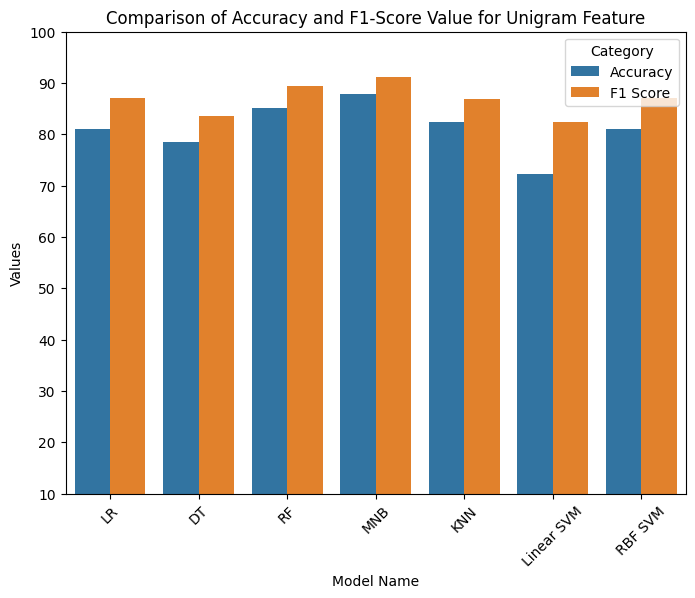

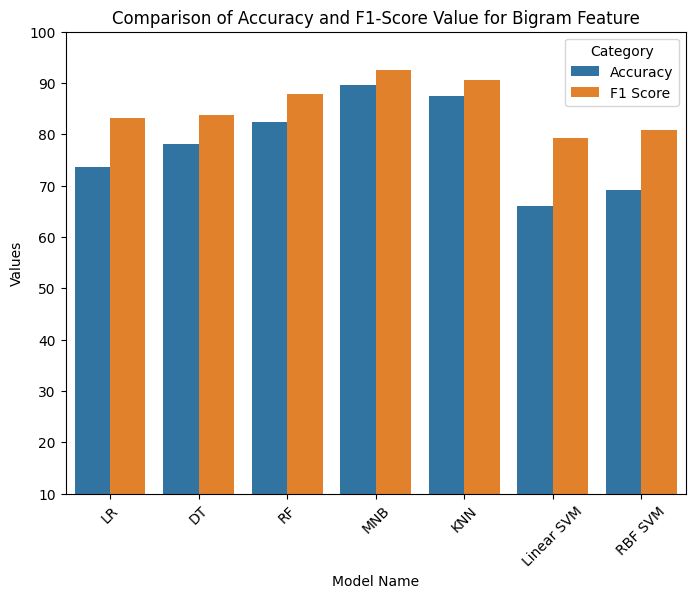

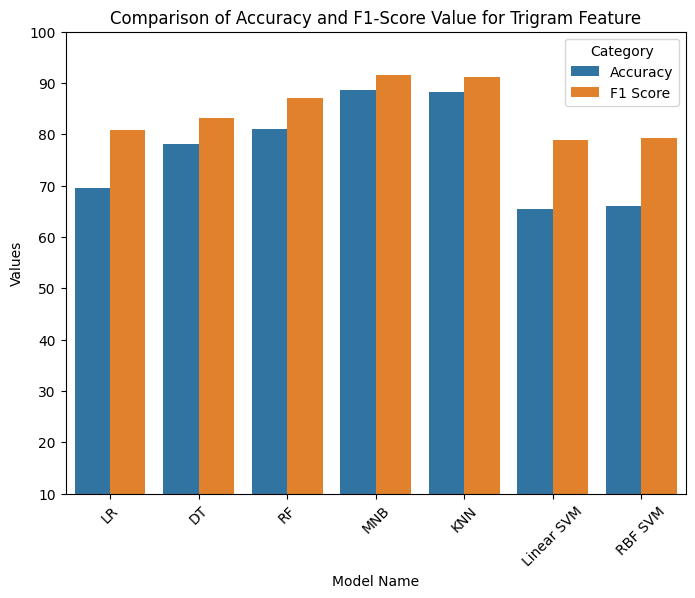

In [24]:
gram_names = ['Unigram','Bigram','Trigram']
for gram in gram_names:
  accuracy = json.load(open(path+f'ml_performance_{gram}.json'))
  table = performance_table(accuracy)
  df = pd.melt(table[['Accuracy','F1 Score','Model Name']], id_vars="Model Name", var_name="Category", value_name="Values")
  plt.figure(figsize=(8,6))
  ax = plt.subplot()
  sns.barplot(data=df,x='Model Name', y='Values' ,hue='Category')
  ax.set_xlabel('Model Name') 
  ax.set_title(f'Comparison of Accuracy and F1-Score Value for {gram} Feature')
  ax.set_ylim([10,100])
  ax.xaxis.set_ticklabels(table['Model Name'], rotation=45);